# Generate nD periodic data

In [1]:
import numpy as np

In [2]:
data_num = 4096
n = 2
m = 25
resolution = 64

In [3]:
values = np.random.choice(2, (data_num, m))
locations = np.random.choice(resolution, (data_num, m, n))

In [4]:
data = np.zeros((data_num, resolution, resolution))

In [5]:
data[np.broadcast_to(np.arange(data_num)[:, None], (data_num, m)), locations[:, :, 0], locations[:, :, 1]] = values

In [6]:
import matplotlib.pyplot as plt

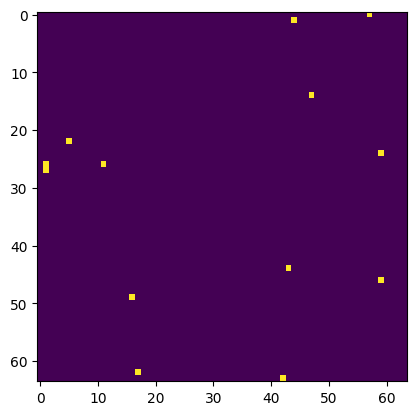

In [7]:
plt.figure()
plt.imshow(data[0])
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
torch.set_default_dtype(torch.float64)

In [10]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the CPU


In [ ]:
class PConvnd(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n):
        super(PConvnd, self).__init__()

        self.padding = (padding, padding)
        self.n = n
        self.padding = (padding, padding)*self.n
        self.convs = {1: nn.Conv1d, 2: nn.Conv2d, 3: nn.Conv3d}
        self.convnd = self.convs[self.n](in_channels, out_channels, 2*padding+1)

    def forward(self, x):
        output = F.pad(x, self.padding, mode = 'circular')
        output = self.convnd(output)
        return output

In [ ]:
class PMaxPoolnd(nn.Module):
    def __init__(self, kernel_size, n):
        super(PMaxPoolnd, self).__init__()

        self.kernel_size = kernel_size
        self.n = n
        self.shifts = torch.cartesian_prod(*((torch.arange(kernel_size),)*n)).tolist()
        self.max_pools = {1: F.max_pool1d, 2: F.max_pool2d, 3: F.max_pool3d}
        self.roll_dims = {1: (-1), 2: (-2, -1), 3: (-3, -2, -1)}

    def forward(self, x):
        rolling = torch.stack([self.max_pools[self.n](torch.roll(x, shift, dims = self.roll_dims[self.n]), 
                                                      self.kernel_size, 
                                                      self.kernel_size) 
                               for shift in self.shifts])
        picked = torch.argmax(torch.sum(rolling.view(self.kernel_size**self.n, x.size(0), -1), dim = -1), dim = 0)
        output = torch.take_along_dim(rolling, picked.view(1, -1, 1, *((1,)*self.n)), dim = 0).squeeze(dim = 0)
        return output, torch.tensor(self.shifts)[picked]

In [ ]:
class PBNEncodernd(nn.Module):
    def __init__(self, conv_dim, latent_dim, n):
        super(PBNEncodernd, self).__init__()
        self.conv_dim = conv_dim
        self.n = n
        self.lin1 = nn.Linear(2**n*conv_dim, latent_dim)
        self.lin2 = nn.Linear(latent_dim, latent_dim)

    def forward(self, x):
        shifts = torch.argmax(torch.sum(x, dim = 1).view(x.shape[0], -1), dim = -1)
        shift_next = shifts
        shift_pull = torch.ones(x.shape[0], x.shape[1], *((1,)*self.n))
        for i in range(self.n):
            shift_axis = shift_next % 2
            shift_next = shift_next // 2
            shift_axis = shift_axis.reshape(shifts.shape[0], 1, *((1,)*self.n))
            shift_axis = 2**i*torch.concat([shift_axis, 1-shift_axis], dim = -1-i)
            shift_pull *= shift_axis

        shift_pull = shift_pull.reshape(shifts.shape[0], 1, -1)

        output = torch.gather(x.reshape(shifts.shape[0], shifts.shape[1], -1), -1, shift_pull)
        output = output.view(-1, 2**self.n*self.conv_dim)
        output = F.relu(self.lin1(output))
        output = self.lin2(output)
        return output, shifts

In [ ]:
class PUpsamplend(nn.Module):
    def __init__(self, scale_factor, n):
        super(PUpsamplend, self).__init__()
        self.scale_factor = scale_factor
        self.n = n
        self.conv_transposes = {1: F.conv_transpose1d, 2: F.conv_transpose2d, 3: F.conv_transpose3d}

    def forward(self, x, shifts):
        w = x.new_zeros(*((self.scale_factor,)*self.n))
        w.view(-1)[0] = 1
        output = self.conv_transposes[self.n](x, w.expand(x.size(1), 1, *((self.scale_factor,)*self.n)), stride = self.scale_factor, groups = x.size(1))
        for i in range(self.n):
            indices = (torch.arange(output.shape[2+i])[None, None, :].repeat(1, 2, 1) - shifts[:, i][:, None, None]) % output.shape[2+i]
            output = torch.gather(output, 2+i, indices)
        return output

In [ ]:
class PBNDecoder(nn.Module):
    def __init__(self, conv_dim, latent_dim, n):
        super(PBNDecoder, self).__init__()
        self.conv_dim = conv_dim
        self.n = n
        self.lin1 = nn.Linear(latent_dim, latent_dim)
        self.lin2 = nn.Linear(latent_dim, 2**n*conv_dim)

    def forward(self, x, shifts):
        output = F.relu(self.lin1(x))
        output = F.relu(self.lin2(output))
        output = output.view(-1, self.conv_dim, 2)
        indices = (torch.arange(output.shape[2])[None, None, :].repeat(1, output.shape[1], 1) + shifts[:, None, None]) % output.shape[2]
        output = torch.gather(output, 2, indices)
        return output